In [137]:
from sklearn.datasets import load_boston
import os



import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from IPython.display import display
# boston = load_boston()


In [138]:
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))


column_names = ['fileId', 'row','rising_idx','falling_idx','volume','rising_weight',
                'falling_weight', 'first_val', 'last_val', 'delay']
def filterBad(dataset):
    initial_len = len(dataset)
    dataset = dataset[(dataset['rising_idx'] != 0)]
    dataset = dataset[(dataset['falling_idx'] != 0)]
    dataset = dataset[(dataset['volume'] > 500)]
#     dataset = dataset[(dataset['first_val'] < 30)]
#     dataset = dataset[(dataset['last_val'] < 30)]
    final_len = len(dataset)
    print('Rejected %d points (%f%%)' % ((initial_len-final_len), (initial_len-final_len)/initial_len))
    return dataset

raw_dataset =  pd.read_feather('../preprocessing/processed.feather')
raw_dataset = filterBad(raw_dataset)
# visualize_dataset = raw_dataset.sample(frac=0.01)
# sns.pairplot(visualize_dataset[column_names], diag_kind="kde")


dataset = raw_dataset.copy()
dataset.tail()

dataset = dataset.dropna()
dataset = dataset.drop(columns=['fileId', 'row'])
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
# dataset.tail()
# train_dataset = dataset.sample(frac=0.8,random_state=0)
# test_dataset = dataset.drop(train_dataset.index)
# # sns.pairplot(train_dataset[["row", "rising_idx", "falling_idx", "volume", "rising_weight", "falling_weight", "delay"]], diag_kind="kde", kind="reg")
# train_stats = train_dataset.describe()
# train_stats.pop("delay")
# train_stats = train_stats.transpose()
# train_stats
# train_labels = train_dataset.pop('delay')
# test_labels = test_dataset.pop('delay')



from sklearn.model_selection import train_test_split

X, y = dataset.iloc[:,:-1],dataset.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
train_dataset, test_dataset, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=123)


Rejected 1810263 points (0.166070%)


In [139]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# fig = plt.figure()
# dataset.plot.scatter(x='rising_idx',y='delay')


In [140]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9090347 entries, 0 to 10900607
Data columns (total 8 columns):
rising_idx        int64
falling_idx       int64
volume            int64
rising_weight     float64
falling_weight    float64
first_val         int64
last_val          int64
delay             float64
dtypes: float64(3), int64(5)
memory usage: 624.2 MB


In [141]:
import pickle
import json
# import jsonpickle

def export_params(xg_reg):
    xg_reg.get_booster().dump_model('example_params')
#     xg_reg.dump_model('example_params')
    # xg_reg.get_booster().get_dump()
    numlines = len(open('example_params').readlines(  ))

    import numpy
    import math
    fields = {}
    threshes = {}
    lefts = {}
    rights = {}
    tree = -1
    num_nodes = int(math.pow(2,MAX_DEPTH+1))

    with open('example_params') as file:
        for cnt, line in enumerate(file):
            if (not 'booster' in line):
                idx = int(line.strip().split(':')[0])
                if ('leaf=' in line):
                    thresh = float(line.strip().split('leaf=')[-1])
                    fields[idx] = ''
                    threshes[idx] = thresh
                else:
                    fields[idx] = line.strip().split('[')[1].split('<')[0]
                    threshes[idx] = float(line.strip().split('[')[1].split('<')[1].split(']')[0])
                    lefts[idx] = int(line.strip().split('yes=')[1].split(',')[0])
                    rights[idx] = int(line.strip().split('no=')[1].split(',')[0])
            if (('booster' in line and cnt != 0) or cnt == numlines-1):
                tree = tree + 1
                scala = ['("", 0.to[T])' for i in range(num_nodes)]

                # Decompress the tree into a complete tree
                leftsArr = [lefts[0]]
                rightsArr = [rights[0]]
                scala[0] = '("%s", %f.to[T])' % (fields[0], threshes[0])
                for idx in range(1,num_nodes):
                    if (idx % 2 == 1 and leftsArr[int(idx/2)] != None):
                        lookup = leftsArr[int(idx/2)]
                    elif (idx % 2 == 0 and rightsArr[int(idx/2)-1] != None):
                        lookup = rightsArr[int(idx/2)-1]
                    else: lookup = None

                    if (lookup != None):
                        scala[idx] = '("%s", %f.to[T])' % (fields[lookup], threshes[lookup])
                        if (lookup in lefts):
                            leftsArr.append(lefts[lookup])
                        else:
                            leftsArr.append(None)
                        if (lookup in rights):
                            rightsArr.append(rights[lookup])
                        else:
                            rightsArr.append(None)
                    else:
                        leftsArr.append(None)
                        rightsArr.append(None)


                print('val tree%d = List(' % tree + ','.join(scala).replace(' ','') + ')')
                fields = {}
                threshes = {}
                lefts = {}
                rights = {}

    print('val trees = List(%s)' % ','.join(['tree%d' % d for d in range(tree+1)]))
    print('val base_score = %f' % BASE_SCORE)
    #         print("Line {}: {}".format(cnt, line))

# export_params(xg_reg)


In [142]:
# dataset.describe

In [143]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np


# Make and train model

In [148]:
# hyperparameters
NUM_TREES = [30]
MAX_DEPTH = [5]
BASE_SCORE = 0.5
COLSAMPBYTREE=[0.3]
LR = [0.9]
LAMBDA=[2]
ALPHA = [10]

for a in ALPHA:
    for c in COLSAMPBYTREE:
        for l in LR:
            for la in LAMBDA:
                for nt in NUM_TREES:
                    for md in MAX_DEPTH:
                        print("%f %f %f %f %f %f:" % (a,c,l,la,nt,md))

                        xg_reg = xgb.XGBRegressor(objective ='reg:linear', base_score = BASE_SCORE, 
                                                  colsample_bytree = c, learning_rate = l,
                                                  max_depth = md, alpha = a, n_estimators = nt, reg_lambda = la)

                        # xg_reg.print_evaluation()
                        xg_reg.fit(X_train,y_train)


                        preds = xg_reg.predict(X_test)
                        rmse = mean_squared_error(y_test, preds)
                        rmae = mean_absolute_error(y_test, preds)
                        r2 = r2_score(y_test, preds)
                        print("MSE, MAE, r2: %f,%f,%f" % (rmse, rmae, r2))

TypeError: 'int' object is not iterable

In [146]:
preds = xg_reg.predict(X_test)
rmse = mean_squared_error(y_test, preds)
rmae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("MSE, MAE, r2: %f,%f,%f" % (rmse, rmae, r2))

MSE, MAE, r2: 3550.768786,32.629835,0.997501


In [149]:
NUM_TREES = 30
MAX_DEPTH = 5
BASE_SCORE = 0.5
COLSAMPBYTREE=0.3
LR = 0.9
LAMBDA=2
ALPHA = 10

print(preds)
export_params(xg_reg)

[-1912.6556    387.4435   1176.8447  ...   580.23596   653.9736
 -2499.4158 ]
val tree0 = List(("volume",12430210.000000.to[T]),("falling_weight",-14188.400400.to[T]),("volume",13990577.000000.to[T]),("volume",9607180.000000.to[T]),("volume",4328165.000000.to[T]),("falling_weight",-14987.099600.to[T]),("falling_weight",-16921.900400.to[T]),("volume",580522.000000.to[T]),("volume",11354969.000000.to[T]),("falling_weight",-6435.470210.to[T]),("falling_weight",-11053.400400.to[T]),("falling_weight",-20465.300800.to[T]),("falling_weight",-11053.400400.to[T]),("falling_weight",-20465.300800.to[T]),("falling_weight",-11053.400400.to[T]),("falling_weight",-20465.300800.to[T]),("falling_weight",-18776.300800.to[T]),("volume",10500894.000000.to[T]),("falling_weight",-14987.099600.to[T]),("volume",510581.000000.to[T]),("volume",2103444.000000.to[T]),("volume",5322437.000000.to[T]),("falling_weight",-7637.430180.to[T]),("",-876.183044.to[T]),("falling_weight",-15627.099600.to[T]),("falling_weight

In [17]:
# params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
#                 'max_depth': MAX_DEPTH, 'alpha': 10, 'n_estimators': NUM_TREES}

# cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
#                     num_boost_round=50,early_stopping_rounds=20,metrics="rmse", as_pandas=True, seed=123)

In [18]:
# cv_results.tail()

In [19]:
# print((cv_results["test-rmse-mean"]).tail(1))

In [20]:
# print(type(cv_results))

ImportError: You must install graphviz to plot tree

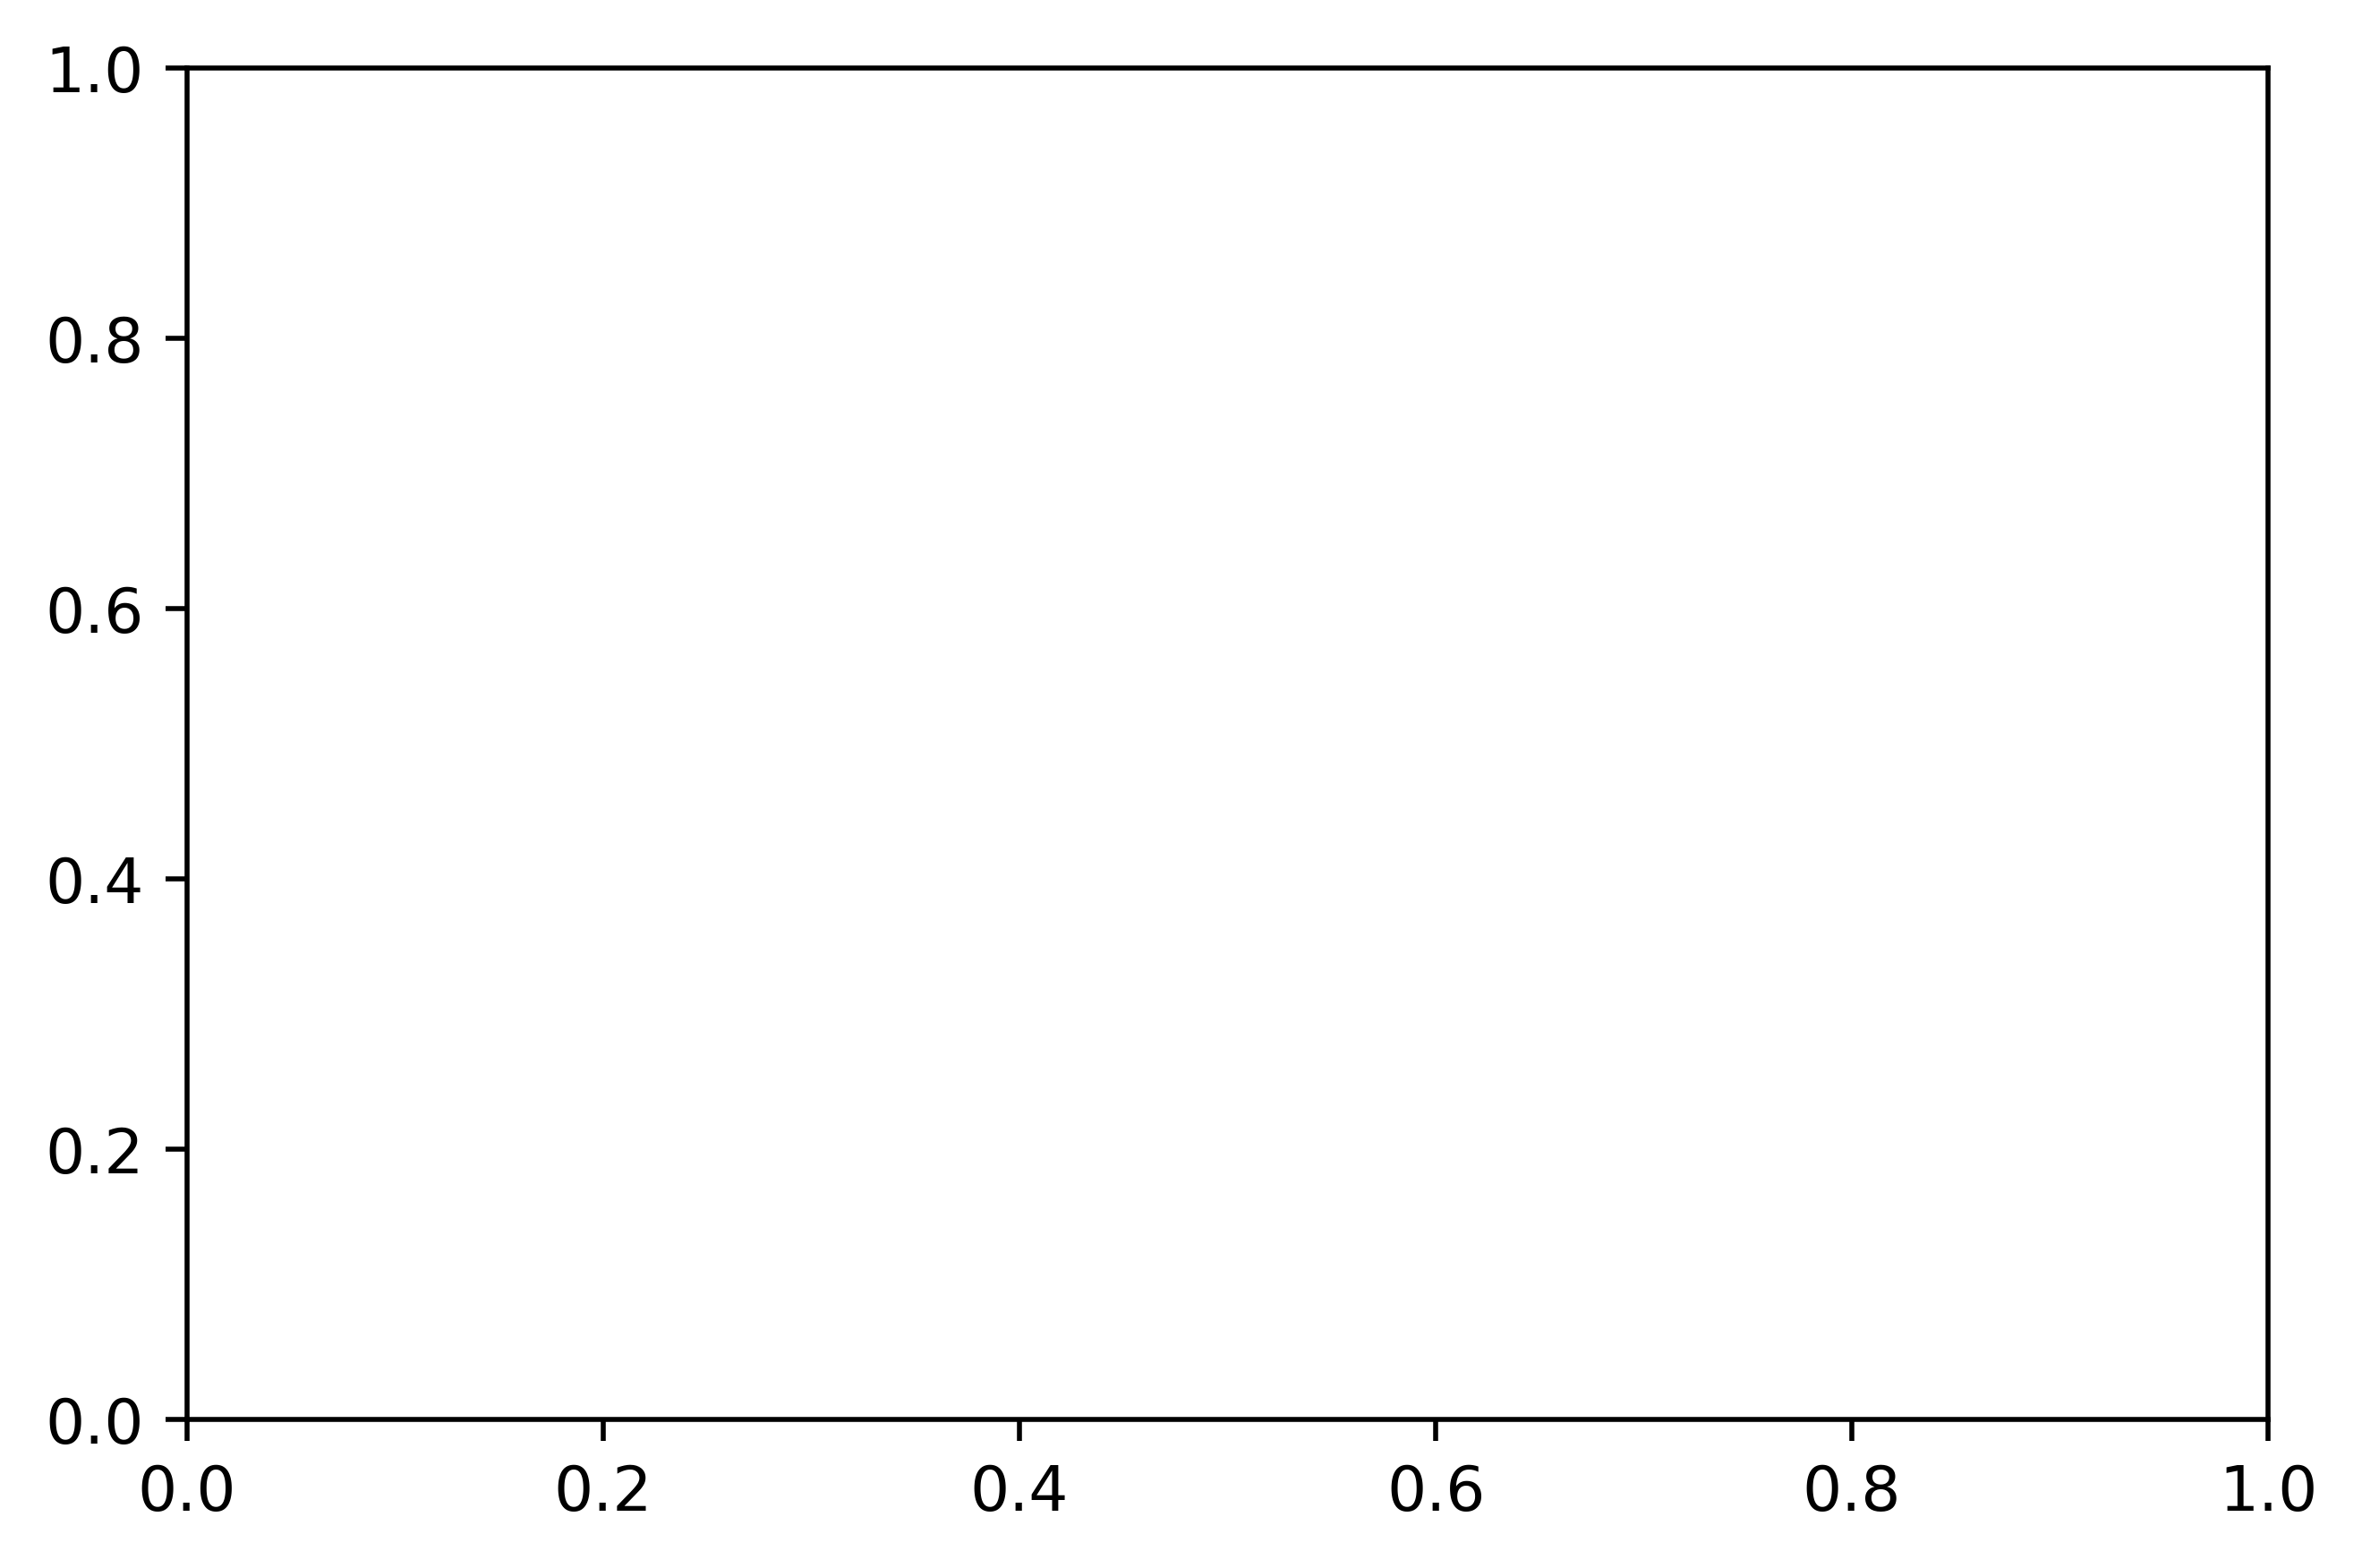

In [21]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 500

xgb.plot_tree(xg_reg,num_trees=1)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [150]:
# df2 = xgb.DMatrix(pd.DataFrame({"rising_idx":[157],
#     "falling_idx":[341],
#     "volume":[12039],
#     "rising_weight":[35.2498],
#     "falling_weight":[-28.1037]}))
df2 = pd.DataFrame({"rising_idx":[157],
    "falling_idx":[341],
    "volume":[12039],
    "rising_weight":[35.2498],
    "falling_weight":[-28.1037], 
    "first_val":[12],
    "last_val":[0]})
print(xg_reg.predict(df2))
print('True label = %f' % 509.093)

[479.70453]
True label = 509.093000


In [ ]:
preds = xg_reg.predict(X_test)xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50,10]
plt.show()